In [84]:
from pharynx_analysis import (
    pharynx_io as pio, image_processing as ip, 
    experiment, plots, profile_processing, data_analysis
)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import skimage
import logging
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns
from skfda import FDataGrid
import skfda
from statsmodels.stats.weightstats import DescrStatsW
from scipy import signal
import matlab.engine
import matlab
import pandas as pd
from pathlib import Path

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(data_analysis)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [100]:
ex.trimmed_profiles

<xarray.DataArray (strain: 123, wavelength: 5, pair: 2, position: 300)>
array([[[[2430.062272, ..., 3061.55931 ],
         [2398.245657, ..., 3033.645716]],

        ...,

        [[-269.796856, ..., -273.035858],
         [-271.184084, ..., -271.219133]]],


       ...,


       [[[2624.962644, ..., 3162.391999],
         [2832.113647, ..., 3312.556073]],

        ...,

        [[-270.228976, ..., -274.275167],
         [-271.369439, ..., -272.962417]]]])
Coordinates:
  * wavelength  (wavelength) object '470' '410' 'r' 'oxd' 'e'
  * strain      (strain) object 'HD233' 'HD233' 'HD233' ... 'SAY47' 'SAY47'
  * pair        (pair) int64 0 1
Dimensions without coordinates: position
Attributes:
    r_min:               0.852
    r_max:               6.65
    instrument_factor:   0.171
    midpoint_potential:  -265.0
    z:                   2
    temperature:         22.0
    strategy:            cata

12:28:28 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
12:28:28 INFO:Loading Images
12:28:28 INFO:Segmenting pharynxes
12:28:31 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:08<00:00, 15.00it/s]
12:28:41 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 101.37it/s]
12:28:42 INFO:Measuring under midlines
100%|██████████| 123/123 [00:04<00:00, 29.69it/s]
12:28:46 INFO:Trimming intensity data
12:28:47 INFO:Calculating redox measurements
12:28:47 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
12:28:47 INFO:Saving region means to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-07_cata/2017_02_22-HD233_SAY47-summary_table.csv
12:28:48 INFO:Saving profile data to /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-07_cata/2017_02_22-HD233_SAY47-profile_data.

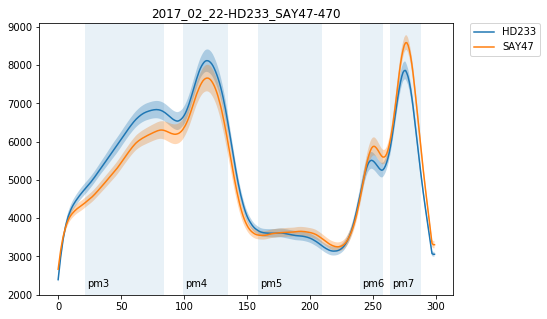

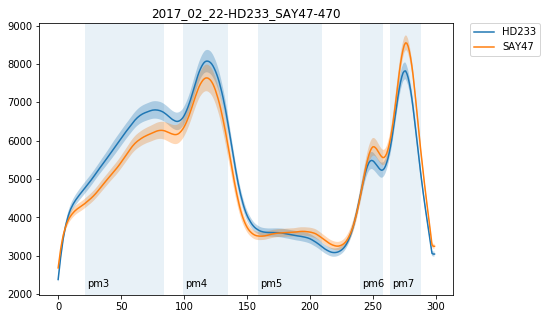

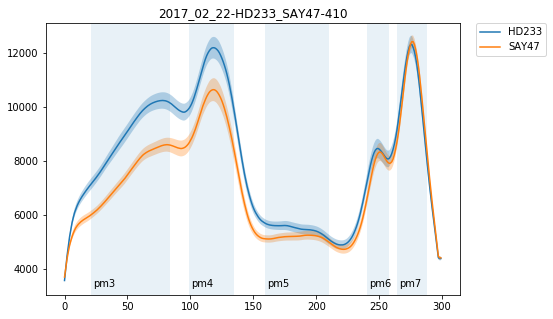

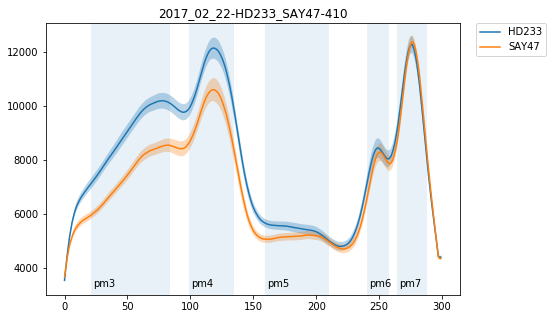

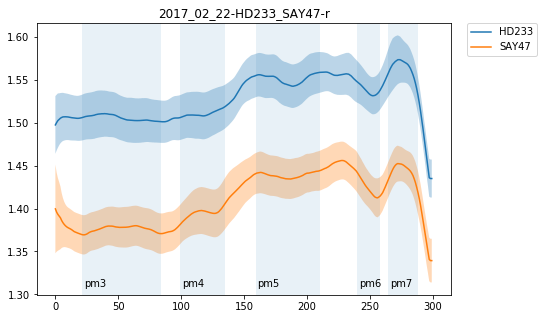

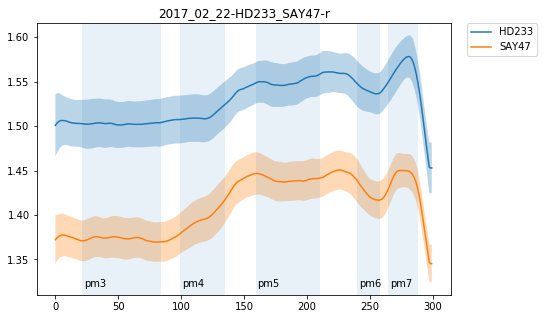

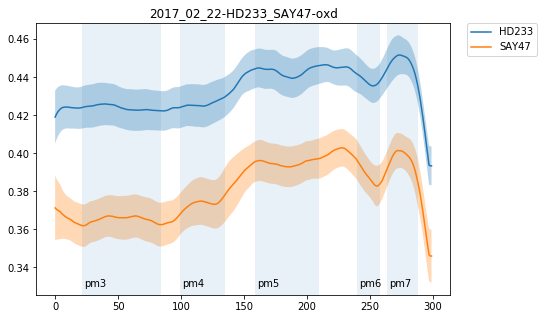

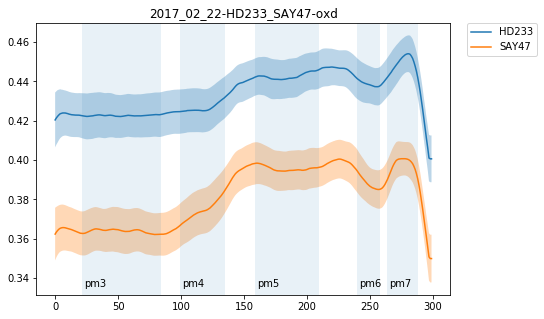

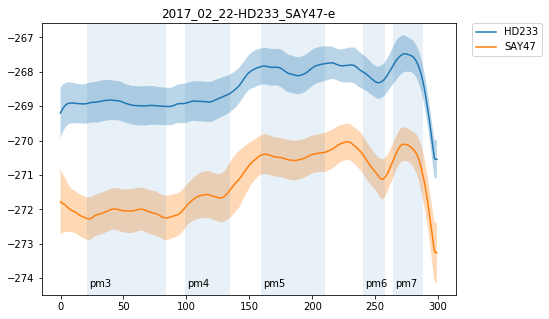

<Figure size 720x360 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

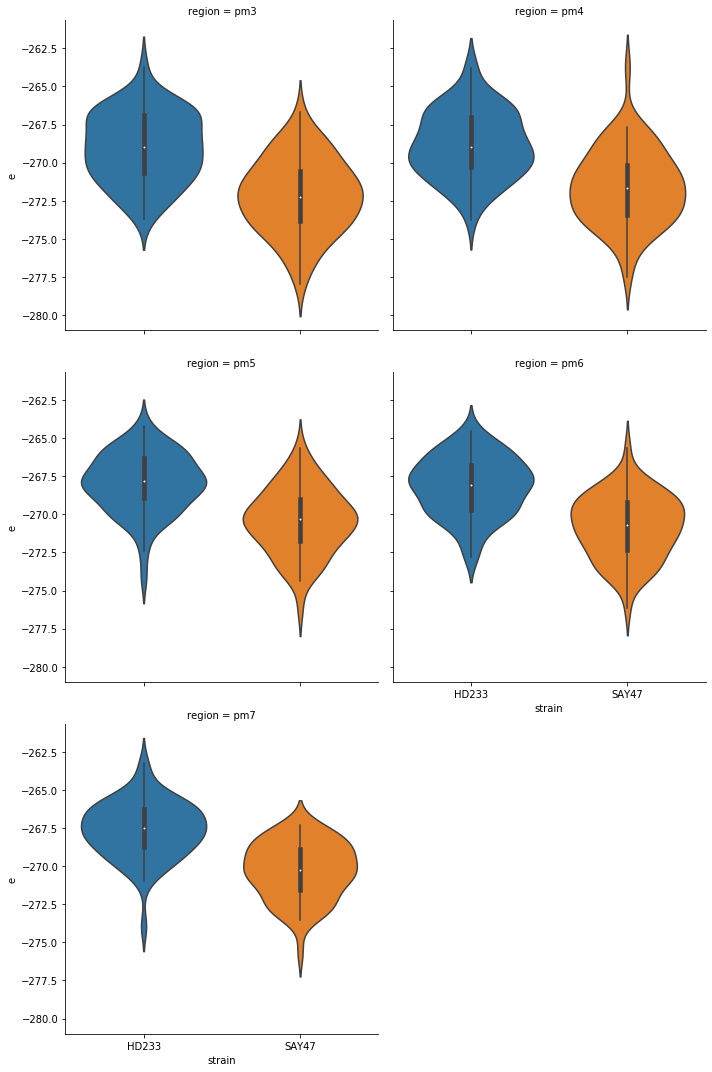

In [99]:
experiment_dir = "/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47"
imaging_scheme = "TL/470/410/470/410"

reload(experiment);
ex = experiment.CataExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme,
    trim_threshold=4000
)
ex.full_pipeline()

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12fdcf208>)

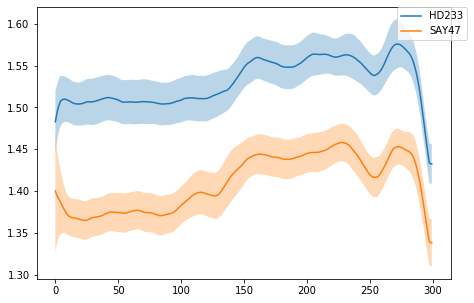

In [269]:
plots.plot_profile_avg_by_strain(ex.trimmed_raw_profiles.sel(wavelength='r', pair=0))

In [288]:
reg_profile_data = profile_processing.register_profiles(ex.raw_profiles, warp_lambda=1e4)

In [30]:
ex.summary_table['total'] =ex.summary_table.anterior + ex.summary_table.posterior + ex.summary_table.sides_of_tip + ex.summary_table.tip

In [42]:
non_movers = ex.summary_table[(ex.summary_table.total == 0) & (ex.summary_table.pair==0) & (ex.summary_table.strategy=='reg')& (ex.summary_table.region=='pm7')].animal
movers = ex.summary_table[(ex.summary_table.total > 0) & (ex.summary_table.pair==0) & (ex.summary_table.strategy=='reg')& (ex.summary_table.region=='pm7')].animal

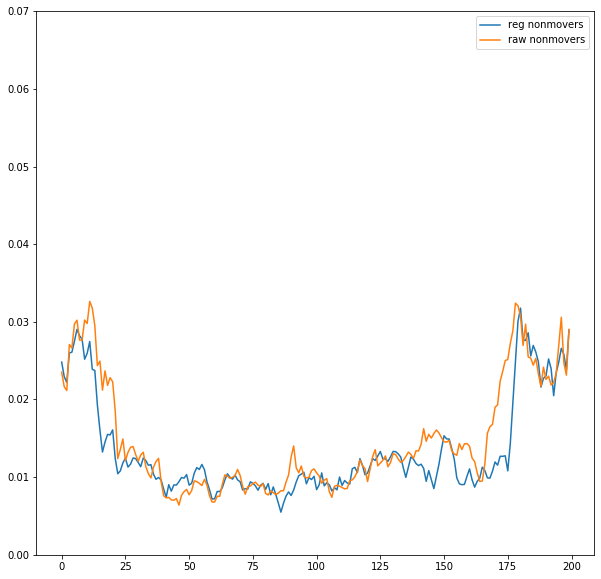

In [49]:
plt.figure(figsize=(10,10))
rr = (ex.reg_profiles.sel(wavelength='410', pair=0) / ex.reg_profiles.sel(wavelength='470', pair=0)) / (ex.reg_profiles.sel(wavelength='410', pair=1) / ex.reg_profiles.sel(wavelength='470', pair=1))
plt.plot(np.median(np.abs(1-rr[non_movers.values]), axis=0), label='reg nonmovers')

rr = (ex.raw_profiles.sel(wavelength='410', pair=0) / ex.raw_profiles.sel(wavelength='470', pair=0)) / (ex.raw_profiles.sel(wavelength='410', pair=1) / ex.raw_profiles.sel(wavelength='470', pair=1))
plt.plot(np.median(np.abs(1-rr[non_movers.values]), axis=0), label='raw nonmovers')
plt.ylim([0, .07])
plt.legend()

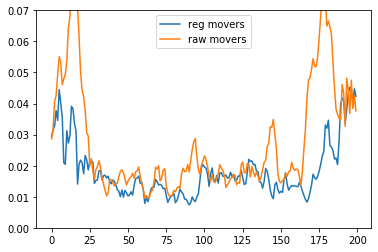

In [55]:
rr = (ex.reg_profiles.sel(wavelength='410', pair=0) / ex.reg_profiles.sel(wavelength='470', pair=0)) / (ex.reg_profiles.sel(wavelength='410', pair=1) / ex.reg_profiles.sel(wavelength='470', pair=1))
plt.plot(np.median(np.abs(1-rr[movers.values]), axis=0), label='reg movers')

rr = (ex.raw_profiles.sel(wavelength='410', pair=0) / ex.raw_profiles.sel(wavelength='470', pair=0)) / (ex.raw_profiles.sel(wavelength='410', pair=1) / ex.raw_profiles.sel(wavelength='470', pair=1))
plt.plot(np.median(np.abs(1-rr[movers.values]), axis=0), label='raw movers')
plt.ylim([0, .07])
plt.legend()